# Starting example: the unicycle

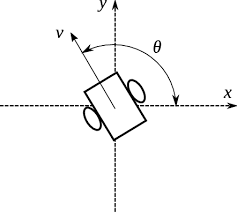

An unicycle represents a kinematic model of a car where it's only possible to move in two directions, i.e. it drives forward and turns on the spot. Its dynamics has nonholonomic constraints because it cannot move sideways. Remember that nonholonomic constraints are nonintegral and has the form $\mathbf{f(q,\dot{q})=0}$.

In this example, we define an optimal-control problem for the classical unicycle problem. Our goal is to drive the unicycle towards the origin but at the same time not too fast. For that, the cost function is described as the sum between the distance to the origin and the system speed.



## Setup

In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


An optimal control problem is:
$$\min_u \int_0^T L(x(t),u(t))dt + \Phi(x(T))$$
$$\dot{x} = f(x,u)$$
where $x$ is the state variable, $u$ the control. For contact and collision, we could add continuous equality and/or equality constraint.

Control in acceleration through as with the dynamic like in the previous TP is achieved thanks to using $\tilde{x} = \left(\begin{array}{c}
  x \\
  \dot{x}
\end{array}\right)
$, $u=\tau$ and $f(\tilde{x},u) = \left(\begin{array}{c}
  \dot{x} \\
  dynamic(x, \dot{x}, \tau)
\end{array}\right)
$

### Crocoddyl
Crocoddyl stands for Contact robot control with differential dynamic programming library. We will need it for formulating and solving the optimal control problems. 

DDP is a second order method to solve the direct discretized version of the previous problem in a simple shooting flavor. As for previous problematic in robotic, recent research propose variation of DDP usefull in the case of robotic. [proxDDP](https://hal.archives-ouvertes.fr/hal-03597630/document)

## Introducing Crocoddyl
Basically, our optimal control problem has the following dynamical model and cost function:

In [2]:
import numpy as np
x = np.random.rand(3)  # x, y, t
u = np.random.rand(2)  # v, w

# Unicycle dynamical model
v,w = u
c,s = np.cos(x[2]),np.sin(x[2])
dt = 1e-2
dx = np.array([ v*c, v*s, w ])  # In world ref
xnext = x + dx*dt

# Cost function: driving to origin (state) and reducing speed (control)
stateWeight = 1
ctrlWeight = 1
costResiduals = np.concatenate([stateWeight*x,ctrlWeight*u])
cost = .5* sum(costResiduals**2)

For this basic example, the unicycle model is coded in the library [Crocoddyl](https://gepettoweb.laas.fr/doc/loco-3d/crocoddyl/master/doxygen-html/). We will just load it and use it. If you are very curious, have a look! It is in crocoddyl/unicycle.py.

Here the cost is $L(x,u) = \frac{1}{2}(A_s \|x\|^2 + A_u \|u\|^2)$, it encode the goal of driving the car to the origin, while using as less trust as possible. $A_s$ and $A_u$ tune the tradeoff between control use and importance of reaching the target soon enough..

We create such a model with the following lines:

In [3]:
import crocoddyl
model = crocoddyl.ActionModelUnicycle()
data  = model.createData()

The action model contains ... well ... the description of the dynamics and cost function. There you find also the action model parameters (here the time step and the cost weights). On the other hand, the data has the buffers where the results of the calculus are stored.

We decided for this separation for an obvious reason that is given just below.

In [4]:
model.costWeights = np.array([
    1,   # state weight
    1  # control weight
])

**You can further understand the mathematical definition of action models see introduction_to_crocoddyl.ipynb**

## I. Defining the shooting problem
A shooting problem is defined by the initial state from which computing the rollout and a sequence of action models.


In [5]:
x0 = np.matrix([ -1., -1., 1. ]).T #x,y,theta
T  = 20
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model)

Here we define a problem starting from $\mathbf{x}_0$ with 20 timesteps (of 0.1 sec by default implementation of unicycle). The terminal action model is defined using the running action model.

This defines the model, not any algorithm to solve it. The only computation that the problem can provide is to integrate the system for a given sequence of controls.

In [6]:
us = [ np.matrix([1., 1.]).T for t in range(T)]
xs = problem.rollout(us)

The plotUnicycle function plots the system as two arrows that represent the wheels

(-2.0, 2.0, -2.0, 2.0)

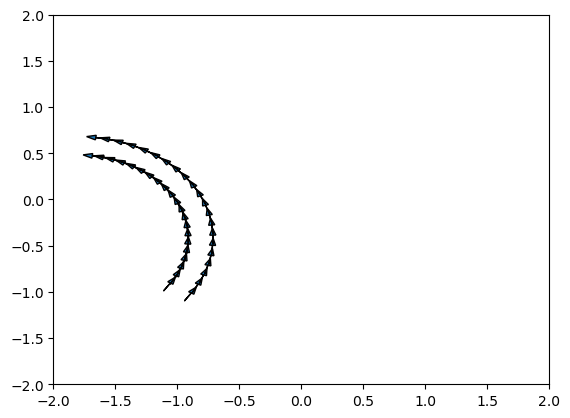

In [7]:
%matplotlib inline
import matplotlib.pylab as plt
from tp5.unicycle_utils import plotUnicycle
for x in xs: plotUnicycle(x)
plt.axis([-2,2.,-2.,2.])

## II. Solve the OCP
The main solver is named SolverDDP. It is initialized from the problem object and mostly contains the ddp.solve method. We can warm start it and tune the parameters, but for the simple unicycle, let's just solve it!

In [8]:
ddp = crocoddyl.SolverDDP(problem)
done = ddp.solve()
assert(done)

[-0.21122711 -0.35525074  0.28127609]


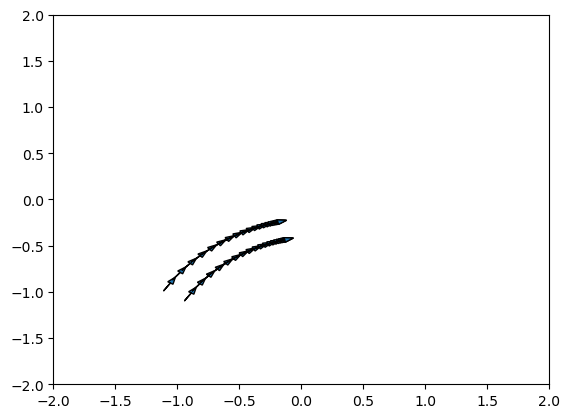

In [9]:
plt.clf()
for x in ddp.xs: plotUnicycle(x)
plt.axis([-2,2,-2,2])
print(ddp.xs[-1])

and the final state is:

In [10]:
print(ddp.xs[-1])

[-0.21122711 -0.35525074  0.28127609]


## Well, the terminal state is not so nicely in the origin.

Question 1: why?

Question 2: How can you change this? Create a new DDP problem

Question 3: by changing the cost parameters, the time horizon and the initial position, can you trigger a maneuver?

In [12]:
# %load tp5/generated/unicycle_solutions_termmodel
model_term = crocoddyl.ActionModelUnicycle()

model_term.costWeights = np.matrix([
    100,   # state weight
    0  # control weight
]).T

# Define integral+terminal models
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model_term)
ddp = crocoddyl.SolverDDP(problem)


In [13]:
ddp.solve()

True

(-2.0, 2.0, -2.0, 2.0)

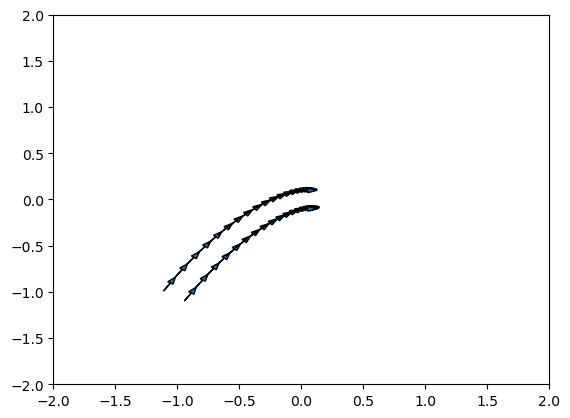

In [14]:
for x in ddp.xs: plotUnicycle(x)
plt.axis([-2,2.,-2.,2.])

# How to use DDP for real robot control
In its natural form DDP tackle the problem of the whole trajectory for a problem. In a a sence it is a motion planning method, however in contract with RRT and/or PRM it is not a global space trajectory. DDP can be use to generate a reference trajectory for a task, and PD controller can be use to follow it with a robot. An other approach callled Modele Predictive Control (MPC) is to solve the DDP on some given horizon and take the first fex step of the control solution as an actual controller for the robot. However despite MPC being of a great appeal, there is a lot of computationnal challenges to be able to control robot at 100Hz.